# Import necessary modules

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import pile data

In [3]:
diameters = np.round(np.arange(0.1, 0.4, 0.025), 3)
select = 3
print(diameters[select])

0.175


In [4]:
# Load the CSV file
csv_filename = f"../pile_D{diameters[select]}.csv" # Replace with your actual file name
data = pd.read_csv(csv_filename)

# Filter data based on pile_number
pile_1_data = data[data["pile_number"] == 1]
pile_2_data = data[data["pile_number"] == 2]
pile_3_data = data[data["pile_number"] == 3]

In [5]:
x = "x"
y = "y"
Ux = "Ux"
Uy = "Uy"
N = "N"
Q = "Q"
M = "M"

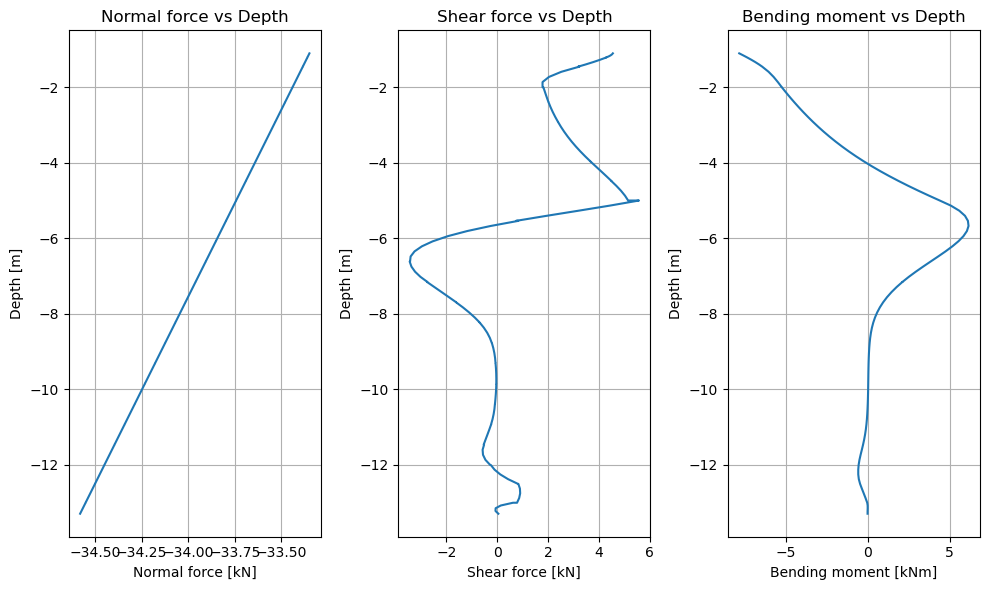

In [6]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
plt.plot(pile_1_data[N], pile_1_data[y])
plt.grid()
plt.xlabel("Normal force [kN]")
plt.ylabel("Depth [m]")
plt.title("Normal force vs Depth")

plt.subplot(1, 3, 2)
plt.plot(pile_1_data[Q], pile_1_data[y])
plt.grid()
plt.xlabel("Shear force [kN]")
plt.ylabel("Depth [m]")
plt.title("Shear force vs Depth")

plt.subplot(1, 3, 3)
plt.plot(pile_1_data[M], pile_1_data[y])
plt.grid()
plt.xlabel("Bending moment [kNm]")
plt.ylabel("Depth [m]")
plt.title("Bending moment vs Depth")

plt.tight_layout()

In [4]:
# Load the CSV
df = pd.read_csv("../softwood_classes.csv")

# Function to get properties for a given class
def get_properties(strength_class):
    row = df[df["Class"] == strength_class]
    if row.empty:
        return f"Class {strength_class} not found."
    return row.to_dict(orient='records')[0]

In [8]:
# Geometry piles
d_pile = diameters[select]*1000 # [mm]
taper = 0 # [mm/m]
soft_shell = 10 # [mm/zijde]

# Timber classes
Klimaatklasses = np.array([1, 2, 3, 4])
Klimaatklasse = Klimaatklasses[0]
Belastingduurklasses = ["Korte termijn", "Lange termijn"]
Belastingduurklasse = Belastingduurklasses[0]
selected_class = "C24"
properties = get_properties(selected_class)

# Input structural forces
y_depth = pile_1_data[y]
N_force = pile_1_data[N]
Q_force = pile_1_data[Q]
M_moment = pile_1_data[M]

print(properties)

{'Class': 'C24', 'fm_k': 24, 'ft_0_k': 14.5, 'ft_90_k': 0.4, 'fc_0_k': 21, 'fc_90_k': 2.5, 'fv_k': 4.0, 'Em_0_mean': 11.0, 'Em_0_k': 7.4, 'Em_90_mean': 0.37, 'Gmean': 0.69, 'rho_k': 350, 'rho_mean': 420}


In [5]:
def houttoets(d_pile, taper, soft_shell, Klimaatklasse, Belastingduurklasse, properties, y_depth, N_force, Q_force, M_moment):

    # Calculate modification factors
    gamma_M = 1.3       # NEN-EN 1995-1-1:2011 art. 2.4.1
    k_mod = 0.7         # NEN-EN 1995-1-1:2011 art. 3.1.3 + NEN 8707:2018+C1:2020       # Voor Korte termijn en Lange termijn
    #k_mod_trek =       # NEN-EN 1995-1-1:2011/NB:2013 art. 3.1.3
    k_def = 2           # NEN-EN 1995-1-1:2011 art. 3.2
    k_m = 1             # NEN-EN 1995-1-1:2011 art. 6.1.6                               # ronde vorm
    k_shape = 1.2       # NEN-EN 1995-1-1:2011 art. 6.1.8                               # ronde vorm
    k_hy = 1            # NEN-EN 1995-1-1:2011 art. 3.2                                 # dieptefactor hoogte h voor buigng
    k_hz = 1            # NEN-EN 1995-1-1:2011 art. 3.2                                 # dieptefactor breedte b voor trek
    k_c90 = 1.5 	    # NEN-EN 1995-1-1:2011 art. 6.1.5                               # elementen op discrete steunpunten

    # Calculate design values for class
    f_t0d = k_mod * k_hz * properties["ft_0_k"] / gamma_M   # [N/mm^2]
    # f_t90d = k_mod_trek * properties["ft_90_k"] / gamma_M # [N/mm^2]
    f_c0d = k_mod * properties["fc_0_k"] / gamma_M          # [N/mm^2]
    f_c90d = k_mod * properties["fc_90_k"] / gamma_M        # [N/mm^2]
    f_myd = k_mod * k_hy * properties["fm_k"] / gamma_M     # [N/mm^2]
    f_mzd = k_mod * k_hz * properties["fm_k"] / gamma_M     # [N/mm^2]
    f_vd = k_mod * properties["fv_k"] / gamma_M             # [N/mm^2]

    # Initialize UC arrays
    UC1 = np.zeros(len(y_depth))
    UC2 = np.zeros(len(y_depth))
    UC3 = np.zeros(len(y_depth))
    UC4 = np.zeros(len(y_depth))
    UC5 = np.zeros(len(y_depth))
    UC6 = np.zeros(len(y_depth))
    UC7 = np.zeros(len(y_depth))
    UC8 = np.zeros(len(y_depth))
    UC9 = np.zeros(len(y_depth))
    UC10 = np.zeros(len(y_depth))
    UC11 = np.zeros(len(y_depth))
    UC12 = np.zeros(len(y_depth))
    UC13 = np.zeros(len(y_depth))
    UC14 = np.zeros(len(y_depth))

    paalkopniveau = y_depth[0] # [m]

    for h in range(len(y_depth)):
        # Calculate the intact diameter of the pile at the current index
        taper_length = paalkopniveau - y_depth[h]                   # [m]
        d_intact = d_pile - taper_length * taper - 2 * soft_shell   # [mm]

        # Calculate cross-section properties at pile depth
        A_b = np.pi * d_intact ** 2 / 4     # [mm^2]
        I_x = np.pi * d_intact ** 4 / 32    # [mm^4]
        I_y = np.pi * d_intact ** 4 / 64    # [mm^4]
        I_z = np.pi * d_intact ** 4 / 64    # [mm^4]
        W_x = np.pi * d_intact ** 3 / 16    # [mm^3]
        W_y = np.pi * d_intact ** 3 / 32    # [mm^3]
        W_z = np.pi * d_intact ** 3 / 32    # [mm^3]
        i_y = np.sqrt(I_y / A_b)            # [mm]
        i_z = np.sqrt(I_z / A_b)            # [mm]

        # Ontwerpcontroles

        # 1 Trek parallel aan de vezel

        # 2 Trek loodrecht

        # 3 Druk parralel
        sigma_c0d = abs(N_force[h]*1000) / A_b   # [N/mm^2]
        UC3[h] = sigma_c0d / f_c0d

        # 4 Druk loodrecht
        
        # 5 Buiging y-as
        sigma_myd = abs(0*1e6) / W_y   # [N/mm^2]
        UC5[h] = sigma_myd / f_myd

        # 6 Buiging z-as
        sigma_mzd = abs(M_moment[h]*1e6) / W_z   # [N/mm^2]
        UC6[h] = sigma_mzd / f_mzd

        # 7,8 Buiging volgens beide assen
        UC7[h] = sigma_myd/f_myd + k_m*sigma_mzd/f_mzd
        UC8[h] = k_m*sigma_myd/f_myd + sigma_mzd/f_mzd

        # 9 Afschuiving
        tau_vd = (4* abs(Q_force[h]*1000)) / (3 * A_b)   # [N/mm^2]
        UC9[h] = tau_vd / f_vd

        # 10 Torsie

        # 11,12 Buiging + trek

        # 13,14 Buiging + druk
        UC13[h] = (sigma_c0d/f_c0d)**2 + sigma_myd/f_myd + k_m*sigma_mzd/f_mzd
        UC14[h] = (sigma_c0d/f_c0d)**2 + k_m*sigma_myd/f_myd + sigma_mzd/f_mzd

    UC_governing = np.zeros(len(y_depth))
    for i in range(len(y_depth)):
        UC_governing[i] = max(UC1[i], UC2[i], UC3[i], UC4[i], UC5[i], UC6[i], UC7[i], UC8[i], UC9[i], UC10[i], UC11[i], UC12[i], UC13[i], UC14[i])

    return UC3, UC6, UC9, UC_governing

UC = 1.682 at -1.10 m


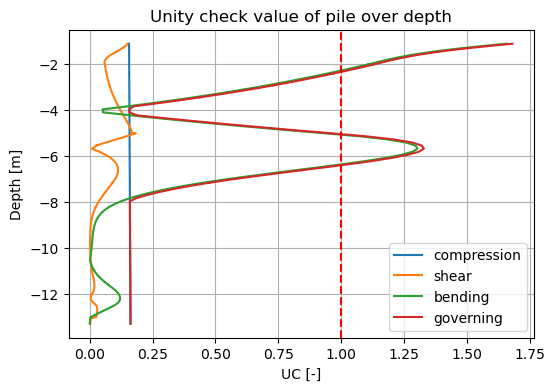

In [10]:
compression, bending, shear, governing = houttoets(d_pile, taper, soft_shell, Klimaatklasse, Belastingduurklasse, properties, y_depth, N_force, Q_force, M_moment)
print(f"UC = {np.max(governing):.3f} at {y_depth[np.argmax(governing)]:.2f} m")

plt.figure(figsize=(6, 4))
plt.plot(compression, y_depth, label="compression")
plt.plot(shear, y_depth, label="shear")
plt.plot(bending, y_depth, label="bending")
plt.plot(governing, y_depth, label="governing")
plt.axvline(1, color='red', linestyle='--')
plt.title("Unity check value of pile over depth")
plt.xlabel("UC [-]")
plt.ylabel("Depth [m]")
plt.grid()
plt.legend();

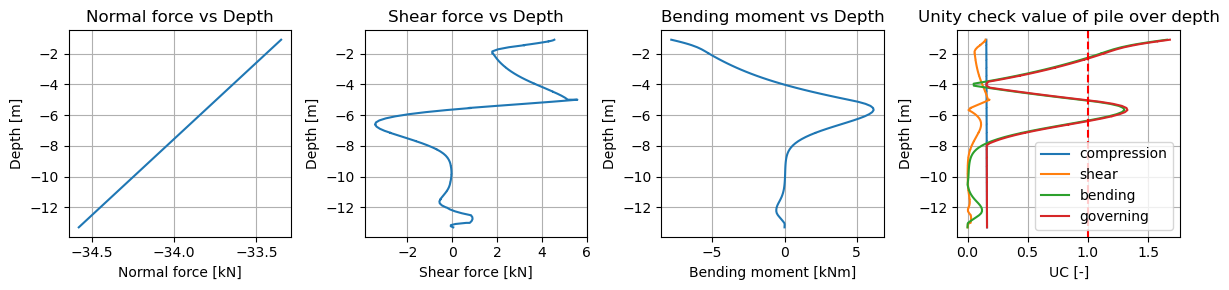

In [11]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 4, 1)
plt.plot(pile_1_data[N], pile_1_data[y])
plt.grid()
plt.xlabel("Normal force [kN]")
plt.ylabel("Depth [m]")
plt.title("Normal force vs Depth")

plt.subplot(1, 4, 2)
plt.plot(pile_1_data[Q], pile_1_data[y])
plt.grid()
plt.xlabel("Shear force [kN]")
plt.ylabel("Depth [m]")
plt.title("Shear force vs Depth")

plt.subplot(1, 4, 3)
plt.plot(pile_1_data[M], pile_1_data[y])
plt.grid()
plt.xlabel("Bending moment [kNm]")
plt.ylabel("Depth [m]")
plt.title("Bending moment vs Depth")

plt.subplot(1, 4, 4)
plt.plot(compression, y_depth, label="compression")
plt.plot(shear, y_depth, label="shear")
plt.plot(bending, y_depth, label="bending")
plt.plot(governing, y_depth, label="governing")
plt.axvline(1, color='red', linestyle='--')
plt.title("Unity check value of pile over depth")
plt.xlabel("UC [-]")
plt.ylabel("Depth [m]")
plt.grid()
plt.legend();

plt.tight_layout()

In [12]:
def houttoets_csv(d_pile, taper, soft_shell, Klimaatklasse, Belastingduurklasse, properties, filename):

    data_original = pd.read_csv(filename)
    data_with_UC = data_original.copy()
    y_depth = data_with_UC["y"]
    N_force = data_with_UC["N"]
    Q_force = data_with_UC["Q"]
    M_moment = data_with_UC["M"]

    # Calculate modification factors
    gamma_M = 1.3       # NEN-EN 1995-1-1:2011 art. 2.4.1
    k_mod = 0.7         # NEN-EN 1995-1-1:2011 art. 3.1.3 + NEN 8707:2018+C1:2020       # Voor Korte termijn en Lange termijn
    #k_mod_trek =       # NEN-EN 1995-1-1:2011/NB:2013 art. 3.1.3
    k_def = 2           # NEN-EN 1995-1-1:2011 art. 3.2
    k_m = 1             # NEN-EN 1995-1-1:2011 art. 6.1.6                               # ronde vorm
    k_shape = 1.2       # NEN-EN 1995-1-1:2011 art. 6.1.8                               # ronde vorm
    k_hy = 1            # NEN-EN 1995-1-1:2011 art. 3.2                                 # dieptefactor hoogte h voor buigng
    k_hz = 1            # NEN-EN 1995-1-1:2011 art. 3.2                                 # dieptefactor breedte b voor trek
    k_c90 = 1.5 	    # NEN-EN 1995-1-1:2011 art. 6.1.5                               # elementen op discrete steunpunten

    # Calculate design values for class
    f_t0d = k_mod * k_hz * properties["ft_0_k"] / gamma_M   # [N/mm^2]
    # f_t90d = k_mod_trek * properties["ft_90_k"] / gamma_M # [N/mm^2]
    f_c0d = k_mod * properties["fc_0_k"] / gamma_M          # [N/mm^2]
    f_c90d = k_mod * properties["fc_90_k"] / gamma_M        # [N/mm^2]
    f_myd = k_mod * k_hy * properties["fm_k"] / gamma_M     # [N/mm^2]
    f_mzd = k_mod * k_hz * properties["fm_k"] / gamma_M     # [N/mm^2]
    f_vd = k_mod * properties["fv_k"] / gamma_M             # [N/mm^2]

    # Initialize UC arrays
    UC1 = np.zeros(len(y_depth))
    UC2 = np.zeros(len(y_depth))
    UC3 = np.zeros(len(y_depth))
    UC4 = np.zeros(len(y_depth))
    UC5 = np.zeros(len(y_depth))
    UC6 = np.zeros(len(y_depth))
    UC7 = np.zeros(len(y_depth))
    UC8 = np.zeros(len(y_depth))
    UC9 = np.zeros(len(y_depth))
    UC10 = np.zeros(len(y_depth))
    UC11 = np.zeros(len(y_depth))
    UC12 = np.zeros(len(y_depth))
    UC13 = np.zeros(len(y_depth))
    UC14 = np.zeros(len(y_depth))

    paalkopniveau = y_depth[0] # [m]

    for h in range(len(y_depth)):
        # Calculate the intact diameter of the pile at the current index
        taper_length = paalkopniveau - y_depth[h]                   # [m]
        d_intact = d_pile - taper_length * taper - 2 * soft_shell   # [mm]

        # Calculate cross-section properties at pile depth
        A_b = np.pi * d_intact ** 2 / 4     # [mm^2]
        I_x = np.pi * d_intact ** 4 / 32    # [mm^4]
        I_y = np.pi * d_intact ** 4 / 64    # [mm^4]
        I_z = np.pi * d_intact ** 4 / 64    # [mm^4]
        W_x = np.pi * d_intact ** 3 / 16    # [mm^3]
        W_y = np.pi * d_intact ** 3 / 32    # [mm^3]
        W_z = np.pi * d_intact ** 3 / 32    # [mm^3]
        i_y = np.sqrt(I_y / A_b)            # [mm]
        i_z = np.sqrt(I_z / A_b)            # [mm]

        # Ontwerpcontroles

        # 1 Trek parallel aan de vezel

        # 2 Trek loodrecht

        # 3 Druk parralel
        sigma_c0d = abs(N_force[h]*1000) / A_b   # [N/mm^2]
        UC3[h] = sigma_c0d / f_c0d

        # 4 Druk loodrecht
        
        # 5 Buiging y-as
        sigma_myd = abs(0*1e6) / W_y   # [N/mm^2]
        UC5[h] = sigma_myd / f_myd

        # 6 Buiging z-as
        sigma_mzd = abs(M_moment[h]*1e6) / W_z   # [N/mm^2]
        UC6[h] = sigma_mzd / f_mzd

        # 7,8 Buiging volgens beide assen
        UC7[h] = sigma_myd/f_myd + k_m*sigma_mzd/f_mzd
        UC8[h] = k_m*sigma_myd/f_myd + sigma_mzd/f_mzd

        # 9 Afschuiving
        tau_vd = (4* abs(Q_force[h]*1000)) / (3 * A_b)   # [N/mm^2]
        UC9[h] = tau_vd / f_vd

        # 10 Torsie

        # 11,12 Buiging + trek

        # 13,14 Buiging + druk
        UC13[h] = (sigma_c0d/f_c0d)**2 + sigma_myd/f_myd + k_m*sigma_mzd/f_mzd
        UC14[h] = (sigma_c0d/f_c0d)**2 + k_m*sigma_myd/f_myd + sigma_mzd/f_mzd

    UC_values = [UC1, UC2, UC3, UC4, UC5, UC6, UC7, UC8, UC9, UC10, UC11, UC12, UC13, UC14]
    for i in range(14):
        data_with_UC[f"UC{i+1}"] = UC_values[i]

    UC_governing = np.zeros(len(y_depth))
    for i in range(len(y_depth)):
        UC_governing[i] = max(UC1[i], UC2[i], UC3[i], UC4[i], UC5[i], UC6[i], UC7[i], UC8[i], UC9[i], UC10[i], UC11[i], UC12[i], UC13[i], UC14[i])
        data_with_UC[f"UC_governing"] = UC_governing
    
    data_with_UC.to_csv(f"UC_D{diameters[select]}.csv")

In [13]:
diameters = np.round(np.arange(0.1, 0.4, 0.025), 3)

for select in range(len(diameters)):
    csv_filename = f"../pile_D{diameters[select]}.csv" # Replace with your actual file name
    d_pile = diameters[select]*1000 # [mm]
    houttoets_csv(d_pile, taper, soft_shell, Klimaatklasse, Belastingduurklasse, properties, csv_filename)

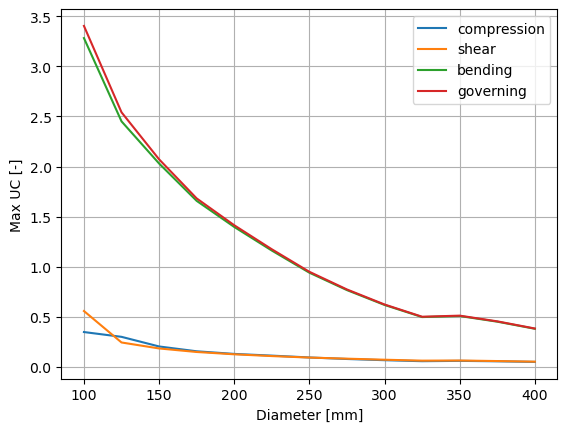

In [18]:
max_UC_values = np.zeros(len(diameters))
max_UCcompression_values = np.zeros(len(diameters))
max_UCshear_values = np.zeros(len(diameters))
max_UCbending_values = np.zeros(len(diameters))
max_UCPUx = np.zeros(len(diameters))
max_UCPUy = np.zeros(len(diameters))
max_UCPUtot = np.zeros(len(diameters))

for select in range(len(diameters)):
    filereq = pd.read_csv(f"UC_D{diameters[select]}.csv")
    max_UCcompression_values[select] = filereq["UC3"][filereq["UC_governing"].idxmax()]
    max_UCshear_values[select] = filereq["UC9"][filereq["UC_governing"].idxmax()]
    max_UCbending_values[select] = filereq["UC6"][filereq["UC_governing"].idxmax()]
    max_UC_values[select] = np.max(filereq["UC_governing"])

    PUxmin = filereq["PUx"].min()
    PUxmax = filereq["PUx"].max()
    max_UCPUx[select]= abs(filereq["PUx"][0])

    PUymin = filereq["PUy"].min()
    PUymax = filereq["PUy"].max()
    max_UCPUy[select]= max(abs(PUymin), abs(PUymax)) * 1000 / 50

    PUtot = filereq["PUtot"].max()
    max_UCPUtot[select] = PUtot * 1000 / 50

plt.plot(diameters*1000, max_UCcompression_values, label="compression")
plt.plot(diameters*1000, max_UCshear_values, label="shear")
plt.plot(diameters*1000, max_UCbending_values, label="bending")   
plt.plot(diameters*1000, max_UC_values, label="governing")
# plt.plot(diameters*1000, max_UCPUx, label="displacement Ux")
# plt.plot(diameters*1000, max_UCPUy, label="displacement Uy")
# plt.plot(diameters*1000, max_UCPUtot, label="displacement Utot")
# plt.title("Unity check values for C24 timber piles, rigidly connected to kesp and with 50 mm displacement criteria")
plt.xlabel("Diameter [mm]")
plt.ylabel("Max UC [-]") 
plt.legend(loc='best')
plt.grid()

In [36]:
def houttoets_addtocsv(d_pile, taper, soft_shell, Klimaatklasse, Belastingduurklasse, properties, filename):

    data_with_UC = pd.read_csv(filename)

    y_depth = data_with_UC["y"]
    N_force = data_with_UC["N"]
    Q_force = data_with_UC["Q"]
    M_moment = data_with_UC["M"]

    # Calculate modification factors
    gamma_M = 1.3       # NEN-EN 1995-1-1:2011 art. 2.4.1
    k_mod = 0.7         # NEN-EN 1995-1-1:2011 art. 3.1.3 + NEN 8707:2018+C1:2020       # Voor Korte termijn en Lange termijn
    #k_mod_trek =       # NEN-EN 1995-1-1:2011/NB:2013 art. 3.1.3
    k_def = 2           # NEN-EN 1995-1-1:2011 art. 3.2
    k_m = 1             # NEN-EN 1995-1-1:2011 art. 6.1.6                               # ronde vorm
    k_shape = 1.2       # NEN-EN 1995-1-1:2011 art. 6.1.8                               # ronde vorm
    k_hy = 1            # NEN-EN 1995-1-1:2011 art. 3.2                                 # dieptefactor hoogte h voor buigng
    k_hz = 1            # NEN-EN 1995-1-1:2011 art. 3.2                                 # dieptefactor breedte b voor trek
    k_c90 = 1.5 	    # NEN-EN 1995-1-1:2011 art. 6.1.5                               # elementen op discrete steunpunten

    # Calculate design values for class
    f_t0d = k_mod * k_hz * properties["ft_0_k"] / gamma_M   # [N/mm^2]
    # f_t90d = k_mod_trek * properties["ft_90_k"] / gamma_M # [N/mm^2]
    f_c0d = k_mod * properties["fc_0_k"] / gamma_M          # [N/mm^2]
    f_c90d = k_mod * properties["fc_90_k"] / gamma_M        # [N/mm^2]
    f_myd = k_mod * k_hy * properties["fm_k"] / gamma_M     # [N/mm^2]
    f_mzd = k_mod * k_hz * properties["fm_k"] / gamma_M     # [N/mm^2]
    f_vd = k_mod * properties["fv_k"] / gamma_M             # [N/mm^2]

    # Initialize UC arrays
    UC1 = np.zeros(len(y_depth))
    UC2 = np.zeros(len(y_depth))
    UC3 = np.zeros(len(y_depth))
    UC4 = np.zeros(len(y_depth))
    UC5 = np.zeros(len(y_depth))
    UC6 = np.zeros(len(y_depth))
    UC7 = np.zeros(len(y_depth))
    UC8 = np.zeros(len(y_depth))
    UC9 = np.zeros(len(y_depth))
    UC10 = np.zeros(len(y_depth))
    UC11 = np.zeros(len(y_depth))
    UC12 = np.zeros(len(y_depth))
    UC13 = np.zeros(len(y_depth))
    UC14 = np.zeros(len(y_depth))

    paalkopniveau = y_depth[0] # [m]

    for h in range(len(y_depth)):

        if data_with_UC["Phase"][h] >= 8:
            soft_shell_used = soft_shell
        else:
            soft_shell_used = 0

        # Calculate the intact diameter of the pile at the current index
        taper_length = paalkopniveau - y_depth[h]                   # [m]
        d_intact = d_pile - taper_length * taper - 2 * soft_shell_used   # [mm]

        # Calculate cross-section properties at pile depth
        A_b = np.pi * d_intact ** 2 / 4     # [mm^2]
        I_x = np.pi * d_intact ** 4 / 32    # [mm^4]
        I_y = np.pi * d_intact ** 4 / 64    # [mm^4]
        I_z = np.pi * d_intact ** 4 / 64    # [mm^4]
        W_x = np.pi * d_intact ** 3 / 16    # [mm^3]
        W_y = np.pi * d_intact ** 3 / 32    # [mm^3]
        W_z = np.pi * d_intact ** 3 / 32    # [mm^3]
        i_y = np.sqrt(I_y / A_b)            # [mm]
        i_z = np.sqrt(I_z / A_b)            # [mm]

        # Ontwerpcontroles

        # 1 Trek parallel aan de vezel

        # 2 Trek loodrecht

        # 3 Druk parralel
        sigma_c0d = abs(N_force[h]*1000) / A_b   # [N/mm^2]
        UC3[h] = sigma_c0d / f_c0d

        # 4 Druk loodrecht
        
        # 5 Buiging y-as
        sigma_myd = abs(0*1e6) / W_y   # [N/mm^2]
        UC5[h] = sigma_myd / f_myd

        # 6 Buiging z-as
        sigma_mzd = abs(M_moment[h]*1e6) / W_z   # [N/mm^2]
        UC6[h] = sigma_mzd / f_mzd

        # 7,8 Buiging volgens beide assen
        UC7[h] = sigma_myd/f_myd + k_m*sigma_mzd/f_mzd
        UC8[h] = k_m*sigma_myd/f_myd + sigma_mzd/f_mzd

        # 9 Afschuiving
        tau_vd = (4* abs(Q_force[h]*1000)) / (3 * A_b)   # [N/mm^2]
        UC9[h] = tau_vd / f_vd

        # 10 Torsie

        # 11,12 Buiging + trek

        # 13,14 Buiging + druk
        UC13[h] = (sigma_c0d/f_c0d)**2 + sigma_myd/f_myd + k_m*sigma_mzd/f_mzd
        UC14[h] = (sigma_c0d/f_c0d)**2 + k_m*sigma_myd/f_myd + sigma_mzd/f_mzd

    UC_values = [UC1, UC2, UC3, UC4, UC5, UC6, UC7, UC8, UC9, UC10, UC11, UC12, UC13, UC14]
    for i in range(14):
        data_with_UC[f"UC{i+1}"] = UC_values[i]

    UC_governing = np.zeros(len(y_depth))
    for i in range(len(y_depth)):
        UC_governing[i] = max(UC1[i], UC2[i], UC3[i], UC4[i], UC5[i], UC6[i], UC7[i], UC8[i], UC9[i], UC10[i], UC11[i], UC12[i], UC13[i], UC14[i])
        data_with_UC[f"UC_governing"] = UC_governing
    
    data_with_UC.to_csv(f"{filename}", index=False)

In [37]:
# Geometry piles
d_pile = 200
years = 100
soft_shell = max(0, years-50)*0.34 # [mm] soft shell thickness
taper = 0 # [mm/m]

# Timber classes
Klimaatklasses = np.array([1, 2, 3, 4])
Klimaatklasse = Klimaatklasses[0]
Belastingduurklasses = ["Korte termijn", "Lange termijn"]
Belastingduurklasse = Belastingduurklasses[0]
selected_class = "C24"
properties = get_properties(selected_class)

# Input structural forces
filename = "Results_embedded_beam.csv"

houttoets_addtocsv(d_pile, taper, soft_shell, Klimaatklasse, Belastingduurklasse, properties, filename)